<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Predict_Students'_Dropout_and_Academic_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Students' Dropout and Academic Success

### **Project Overview**

* **Goal:** To analyze student data to predict academic outcomes (Dropout, Enrolled, or Graduate).
* **Data:** Utilizes the UCI Machine Learning Repository dataset on student dropout and success.
* **Methodology:** Involves advanced data visualization and the training of a **CatBoost** classification model to identify key predictive factors.
* **Key Insight:** Academic performance, particularly semester grades, and socio-economic factors like scholarship status and debt are major indicators of student outcomes.

### **Purpose**

* **Proactive Support:** Identify students at risk of dropping out to provide timely intervention and support.
* **Resource Optimization:** Help educational institutions allocate resources more effectively to improve retention.
* **Improve Policies:** Offer data-driven insights to enhance institutional strategies and foster student success.

### **Dataset**
https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## IMPORT LIBRARIES

In [ ]:
# Install CatBoost
# !pip install -q catboost

# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import catboost as cb
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [ ]:
# Load the dataset from the CSV file
try:
    df = pd.read_csv("/content/drive/MyDrive/Predict Students/data.csv", sep=';')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please upload the file.")
    exit()


Dataset loaded successfully. Shape: (4424, 37)


### Target Variable Encoding

In [ ]:
# Target variable is text-based ('Dropout', 'Enrolled', 'Graduate')
# LabelEncoder to convert these strings into numerical labels - model can understand
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
# We save the mapping for later use in plots and reports.
class_names = le.classes_
print(f"\nTarget variable encoded. Mapping: {dict(zip(range(len(class_names)), class_names))}")



Target variable encoded. Mapping: {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}


### EDA - EXPLORATORY DATA ANALYSIS

### Class Imbalance Visualization

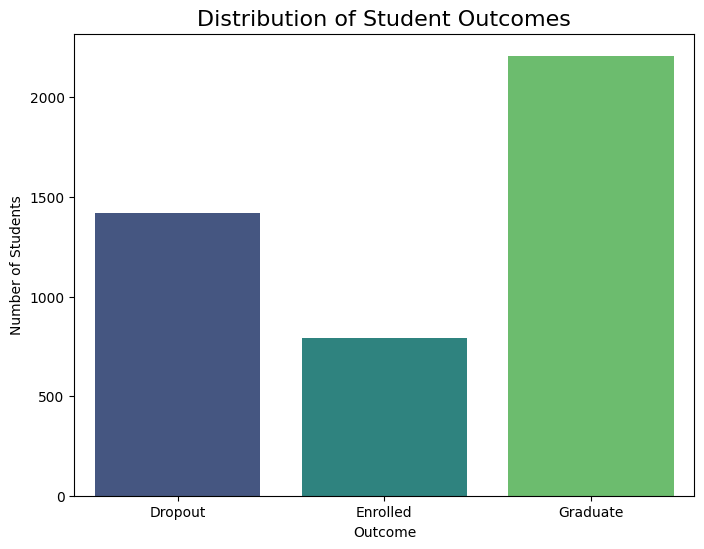

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Target'], palette='viridis')
plt.title('Distribution of Student Outcomes', fontsize=16)
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.ylabel('Number of Students')
plt.xlabel('Outcome')
plt.show()

### Performance Distribution Analysis (Violin Plots)

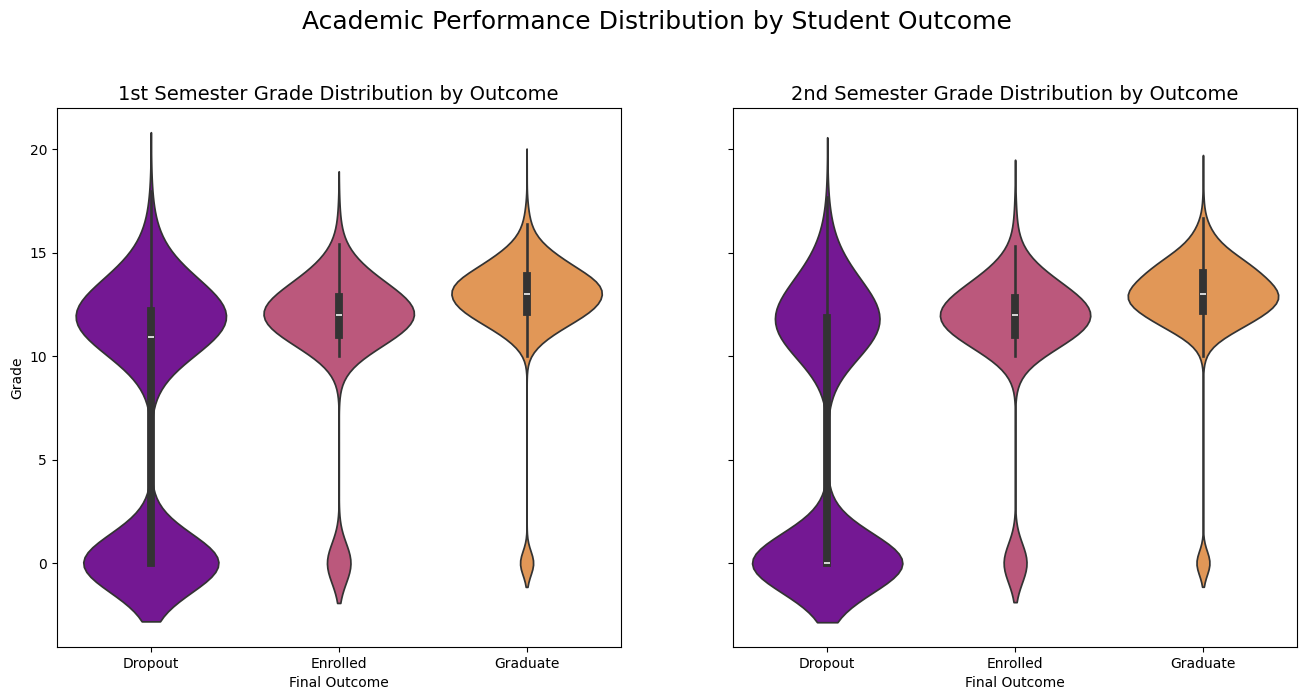

In [ ]:
# Spread and shape of academic performance for each group
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
sns.violinplot(ax=axes[0], x='Target', y='Curricular units 1st sem (grade)', data=df, palette='plasma')
axes[0].set_title('1st Semester Grade Distribution by Outcome', fontsize=14)
axes[0].set_xticklabels(class_names)
axes[0].set_xlabel('Final Outcome')
axes[0].set_ylabel('Grade')

sns.violinplot(ax=axes[1], x='Target', y='Curricular units 2nd sem (grade)', data=df, palette='plasma')
axes[1].set_title('2nd Semester Grade Distribution by Outcome', fontsize=14)
axes[1].set_xticklabels(class_names)
axes[1].set_xlabel('Final Outcome')
axes[1].set_ylabel('')
fig.suptitle('Academic Performance Distribution by Student Outcome', fontsize=18, y=1.02)
plt.show()

### Socio-Economic Impact Analysis

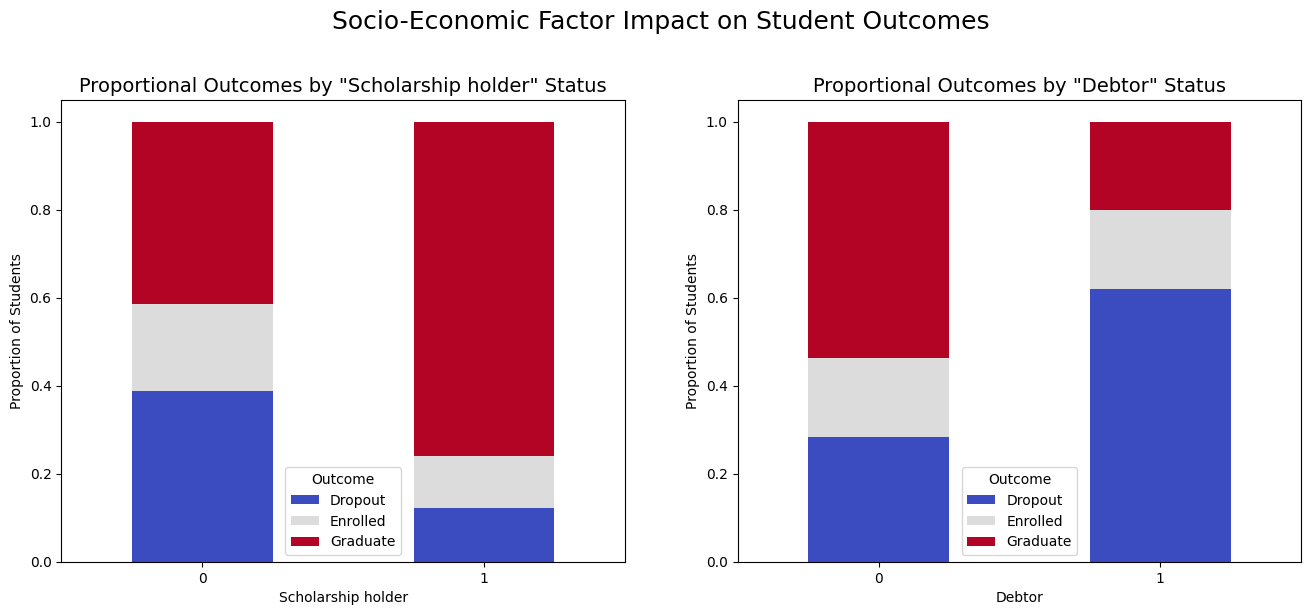

In [ ]:
# Percentage of students in each outcome category
# The dropout rate of debtors vs. non-debtors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
socio_economic_factors = ['Scholarship holder', 'Debtor']
for i, factor in enumerate(socio_economic_factors):
    crosstab = pd.crosstab(df[factor], df['Target'])
    crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)
    crosstab_normalized.plot(kind='bar', stacked=True, ax=axes[i], colormap='coolwarm')
    axes[i].set_title(f'Proportional Outcomes by "{factor}" Status', fontsize=14)
    axes[i].legend(title='Outcome', labels=class_names)
    axes[i].set_ylabel('Proportion of Students')
    axes[i].tick_params(axis='x', rotation=0)
fig.suptitle('Socio-Economic Factor Impact on Student Outcomes', fontsize=18, y=1.03)
plt.show()

## MODELING

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

# Stratify - same proportion of each outcome class as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle Multi-Class Imbalance with Class Weights

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Calculated Class Weights: {class_weights_dict}")

Calculated Class Weights: {0: np.float64(1.0375256523013778), 1: np.float64(1.857742782152231), 2: np.float64(0.6676098849273722)}


In [ ]:
# Train the CatBoost Model

model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    class_weights=class_weights_dict,# Applies our calculated weights
    random_seed=42,
    verbose=0, # Suppress verbose output during training
    early_stopping_rounds=50 # Prevents overfitting
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))
print("Model training complete.")


Model training complete.


## MODEL EVALUATION & INTERPRETATION

In [ ]:
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.83      0.71      0.76       284
    Enrolled       0.43      0.62      0.51       159
    Graduate       0.86      0.81      0.83       442

    accuracy                           0.74       885
   macro avg       0.71      0.71      0.70       885
weighted avg       0.77      0.74      0.75       885



## Confusion Matrix

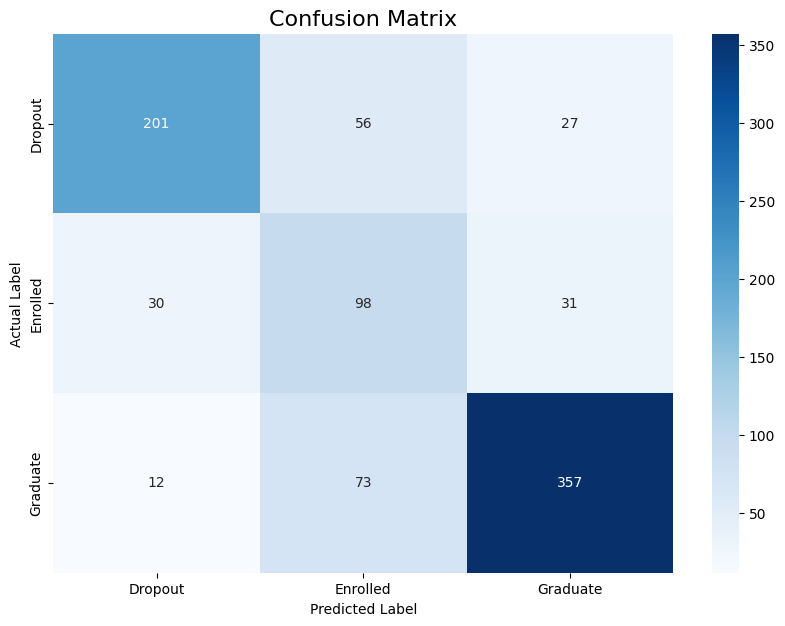

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Feature Importance

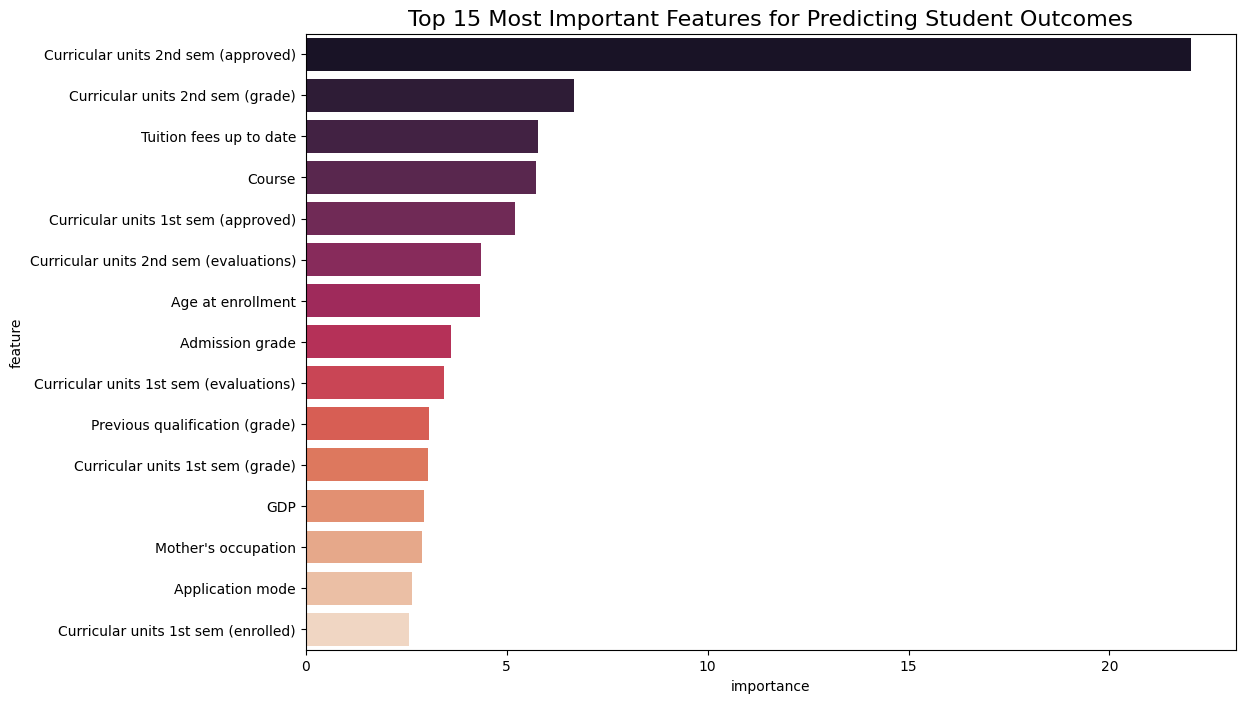

In [ ]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket')
plt.title('Top 15 Most Important Features for Predicting Student Outcomes', fontsize=16)
plt.show()